# An Introduction to Neural Networks: Learning and Controlling the Dubins car

In this assignment, our goal is to **learn a non-linear dynamics using fully connected neural networks** and then control it to fulfill a certain objective. We will employ the Pytorch library, which is an optimized tensor library for deep learning using GPUs and CPUs (https://pytorch.org/).

The non-linear dynamics explored in this project is the (discrete-time) Dubins Car, which represents a simplified model of a vehicle. Let $\tau$ be a step size, $v_t$ the vehicle's heading velocity, $\omega_t$ a control of its steering angle. The Dubins car model can be described as:

\begin{equation}
x_{t+1} = f(x_t, u_t) = \begin{bmatrix}
                      x_{t}^{(1)} + \tau v_t \sin(x_{t}^{(3)}) \\
                      x_{t}^{(2)} + \tau v_t \cos(x_{t}^{(3)}) \\
                      x_{t}^{(3)} + \tau \omega_t
                    \end{bmatrix}
\end{equation}

where $x_{t}^{(1)}$ represents the $x$-position of the car at instant $t$, $x_{t}^{(2)}$ the $y$-position, and $x_{t}^{(3)}$ is its steering angle, and $u_t = (v_t, \omega_t)$ is the control input.

### Instructions

- **Follow instructions throughout the code**: Your tasks are identified as TODOs.

- **Please send us your notebook (.ipynb) containing all the results (WE WON'T RUN YOUR NOTEBOOK)**. We won't open any other supplementary file.

### Preliminaries

In [1]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

from regions import HyperRectangle
from plotting import plot_environment, plot_position_trajectories

from dynamics import DubinsCar
from dataset import Dataset
from neural_network import NeuralNetworkDynamics



torch.manual_seed(0)

##### Define state and control support

We will consider a state support (e.g. a macro safe set) $x_t \in [-3, 3]\times[-3, -3]\times[0, 2\pi]$, and a control support $u_t = (v_t, \omega_t) \in [-1, 1]\times[-0.4, 0.4]$.

In [2]:
# Set support
safe_set = HyperRectangle(torch.tensor([-3.0, -3.0, 0.0]), torch.tensor([3.0, 3.0, 2 * math.pi]))
control_support = HyperRectangle(torch.tensor([-1.0, -0.4]), torch.tensor([1.0, 0.4]))

##### Generating data

To build our dataset, we will randomly select initial states $x$ and control inputs $u=(v, \omega)$ and call the oracle to build a data pair $((x, u), x^{+})$, where $x^{+}$ is the next state given by the underlying dynamics. We will store all those data pairs as a dataset $\mathcal{D} = \{ (x_{n}, u_{n}), x_{n+1}  \}_{n=0}^{N}$.

PS: *Feel free to store this dataset on a separate structure if you want to prevent regenerating data each time you launch the notebook.*

In [3]:
# Generate dataset
N = 10000
oracle = DubinsCar(tau=0.1)
dataset = Dataset(dynamics=oracle, state_support=safe_set, control_support=control_support, dataset_size=N)

Note that the *Dataset* class has a field *extended_input* storing a tensor $(N, 5)$ representing the $N$ observations of $(x, u)$, and a field *output* storing a tensor $(N, 3)$ representing the $N$ observations of the next state given by the underlying dynamics.

In [4]:
X = dataset.data.extended_input # (N, 5)
y = dataset.data.output # (N, 3)

##### Splitting the dataset into training and testing sets

Create tensors **X_train** and **y_train** by randomly selecting 70% of the respective observations in **X** and **y**. The tensors **X_test** and **y_test** will contain the remaining data pairs.



In [5]:
# Split X and y into train and test data
N_train = int(0.7 * N)
N_test = N - N_train

idx = torch.randperm(N)
train_idx = idx[:N_train]
test_idx = idx[N_train:]



# Split data
X_train, y_train = X[train_idx, :], y[train_idx, :]
X_test, y_test = X[test_idx, :], y[test_idx, :]

### Building our first Neural Network
In this Section, we create a **neural network** (hereafter denoted by $f_{\text{NN}}$) which will try to learn the Dubins car dynamics, $f$. In other words, we would like that, for any state $x$ and control input $u$, $f_{\text{NN}}(x, u) \approx f(x, u)$.


In [6]:
# import importlib 
# importlib.reload(neural_network.NeuralNetworkDynamics)

net = NeuralNetworkDynamics() # Implement the class NeuralNetworkDynamics in the file neural_network.py

The weights of our NN are initialized to random values. It is our duty to **train this network (i.e. optimize those weights)** so that our NN model is capable to correctly predict the behavior of the dynamics.

##### Select an appropriate loss function

You can consult, for instance: https://docs.pytorch.org/docs/stable/nn.html#loss-functions

In [7]:
loss_func = nn.MSELoss() # Initialize appropriate loss function for the problem

##### Define an optimizer for the gradient descent
Gradient descent is usually the optimization technique used to minimize the loss. Once we have computed the gradient of the loss $L$ with respect to the weights $w$, there are several ways in which we can update $w$. Pytorch offers various optimizer algorithms for such a task  (https://pytorch.org/docs/stable/optim.html). This paper (https://arxiv.org/pdf/1412.6980.pdf) introduces the Adam algorithm, which we suggest as an initial try.


In [8]:

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-5) # Initialize the optimizer

##### Train the neural network

This is the core task of this assignment. You should implement your own training loop for the NN. You can get some inspiration from the Section "The Training Loop" in https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html

It should be reasonably easy to reach a training loss of around $0.03$, but try to push for better training loss (of course, make sure that your model is also capable of achieving a low testing loss, see next section).

In [9]:
net.train() # Set network to training mode

NeuralNetworkDynamics(
  (net): Sequential(
    (0): Linear(in_features=5, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=3, bias=True)
  )
)

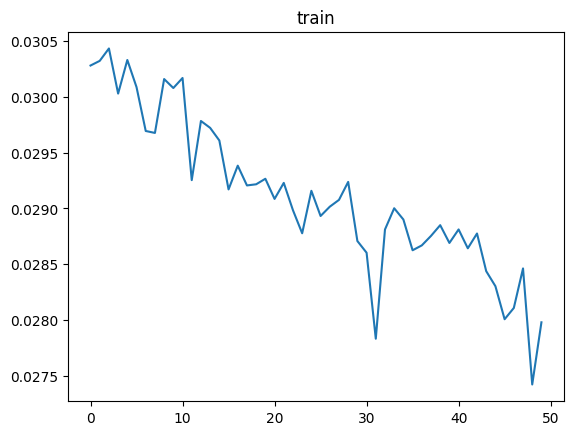

In [49]:
train_set = TensorDataset(X_train, y_train)
test_set  = TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_set, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=False)

def train_epoch():
    n_train = 0
    train_loss_sum = 0
    for i, data in enumerate(train_loader):
        xb, yb = data
        optimizer.zero_grad()
        pred = net.net(xb)
        loss = loss_func(pred, yb)
        loss.backward()
        optimizer.step()

        batch_size = xb.size(0)
        train_loss_sum += loss.item() * batch_size
        n_train += batch_size

    train_loss = train_loss_sum / n_train

    # net.eval()

    # n_test = 0
    # test_loss_sum = 0
    # with torch.no_grad():
    #     for i, data in enumerate(test_loader):
    #         xb, yb = data
    #         pred = net.net(xb)
    #         test_loss = loss_func(pred, yb)
            
    #         batch_size = xb.size(0)
    #         test_loss_sum += test_loss.item() * batch_size
    #         n_test += batch_size
    # test_loss = test_loss_sum / n_test
    return 0, train_loss

# test_losses = []
train_losses = []
no_epochs = 50
for i in range(no_epochs):
    test_loss, train_loss = train_epoch()
    # test_losses.append(test_loss)
    train_losses.append(train_loss)

# plt.figure()
# plt.plot(test_losses)
# plt.title("test")

plt.figure()
plt.plot(train_losses)
plt.title("train")

plt.show()

# Write your own training loop
# Plot the training loss curve (i.e. the number of epochs in the x-axis and the loss in the y-axis)

##### Testing the model
We can assess the generalization capability of our model by comparing the training loss with the loss we obtain using unseen data. That's why we have created a test set.

In [50]:
net.eval() # Set model to evaluation mode
with torch.no_grad(): # Only build forward graph => faster
    y_test_pred = net.net(X_test)

loss_test = loss_func(y_test_pred, y_test) # TODO: Compute loss between y_test_pred and y_test
print('Loss on testing set:', loss_test)
print('Loss on training set:', train_losses[-1])
# Compare the testing loss with the training loss

Loss on testing set: tensor(0.0440)
Loss on training set: 0.027980730446505002


##### Visualizing predictions from the NN

Given the initial state $x_0$ and the control sequence $u_t$ defined below, plot the position coordinates $x^{(1)}_t$ and $x^{(2)}_t$ of the vehicle for each time step and compare with the trajectory you would obtain using the oracle.

tensor([-2.5000, -2.5000,  0.0000,  0.1000,  0.5000])
tensor([-2.4797, -2.5986,  0.1934,  0.3000,  0.7000])
tensor([-2.4314, -2.6348,  0.3330,  0.5000,  0.9000])
tensor([-2.3628, -2.6149,  0.4312,  0.7000,  1.1000])
tensor([-2.2848, -2.5605,  0.4856,  0.9000,  1.1000])
tensor([-2.2001, -2.5026,  0.5126,  1.1000,  1.1000])
tensor([-2.1115, -2.4472,  0.5271,  1.3000,  0.9000])
tensor([-2.0279, -2.4059,  0.5005,  1.5000,  0.7000])
tensor([-1.9409, -2.3746,  0.4320,  1.5000,  0.5000])
tensor([-1.8501, -2.3534,  0.3431,  1.5000,  0.5000])
tensor([-1.7548, -2.3472,  0.3081,  1.5000,  0.5000])
tensor([-1.6573, -2.3460,  0.2882,  1.5000,  0.5000])
tensor([-1.5584, -2.3464,  0.2736,  1.5000,  0.5000])
tensor([-1.4585, -2.3470,  0.2614,  1.3000,  0.1000])
tensor([-1.3582, -2.3451,  0.1171,  1.1000, -0.3000])
tensor([-1.3101, -2.4397,  0.3183,  0.9000, -0.5000])
tensor([-1.2505, -2.4750,  0.2762,  0.7000, -0.7000])
tensor([-1.2575, -2.5540,  0.8068,  0.5000, -1.0000])
tensor([-1.2697, -2.5510,  0

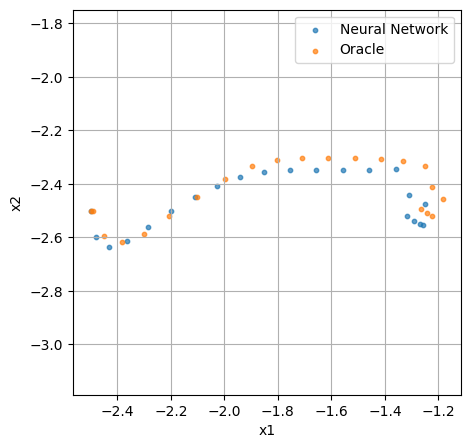

In [51]:
x0 = torch.tensor([-2.5, -2.5, 0.0])
u_sequence = torch.tensor([[0.1, 0.5], [0.3, 0.7], [0.5, 0.9], [0.7, 1.1], [0.9, 1.1], [1.1, 1.1], [1.3, 0.9], [1.5, 0.7], [1.5, 0.5], [1.5, 0.5], [1.5, 0.5], [1.5, 0.5], [1.5, 0.5],
                           [1.3, 0.1], [1.1, -0.3], [0.9, -0.5], [0.7, -0.7], [0.5, -1.0], [0.5, -1.0], [0.5, -1.0]])


traj_nn = []
traj_nn.append(x0)
traj_oracle = [x0]
with torch.no_grad():
    for i in range(u_sequence.size(0)):
        input = torch.cat([traj_nn[-1], u_sequence[i, :]])
        print(input)
        traj_nn.append(net.net(input))
        traj_oracle.append(oracle.forward(input[:3], u_sequence[i, :]))
    # Build a trajectory using the trained NN starting from x_0, given the sequence of control inputs u_sequence, and then plot the two first coordinates of the trajectory (i.e. the position of the car predicted by the NN at each time step). Do the same using the oracle (i.e. the true underlying dynamics). Compare the plots.


plot_position_trajectories(torch.stack(traj_nn), torch.stack(traj_oracle))

### [OPTIONAL] Building a controller

In the previous Section, we constructed a Neural Network capable of effectively approximating the underlying dynamics of the system. Now, we want to use this model to design a controller fulfilling a reach-avoid property.

##### Building a reach-avoid environment

We now consider the existence of an obstacle given by the set $[-1, 0]\times[-1, 0]\times[0, 2\pi]$, and a target set $[1, 2]\times[1, 2]\times[0, 2\pi]$. We would like to design a controller which keeps the vehicle in the safe set, while avoiding the obstacle, and eventually reaching the target. Suppose that you are giving a reference trajectory for the position of the car.

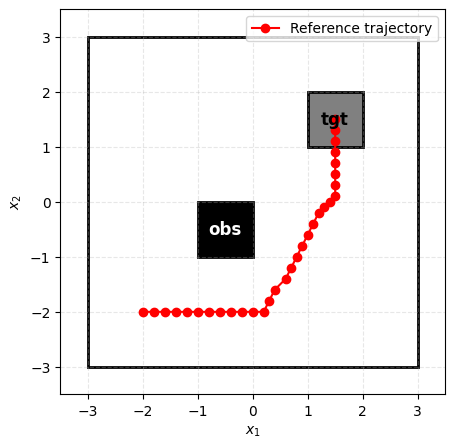

In [52]:
obstacle = HyperRectangle(torch.tensor([-1.0, -1.0, 0.0]), torch.tensor([0.0, 0.0, 2 * math.pi]))
target = HyperRectangle(torch.tensor([1.0, 1.0, 0.0]), torch.tensor([2.0, 2.0, 2 * math.pi]))

reference_trajectory_for_position = torch.tensor([[-2.0, -2.0], [-1.8, -2.0], [-1.6, -2.0], [-1.4, -2.0], [-1.2, -2.0], [-1.0, -2.0],
                                                  [-0.8, -2.0], [-0.6, -2.0], [-0.4, -2.0], [-0.2, -2.0], [0.0, -2.0], [0.2, -2.0],
                                                  [0.3, -1.8], [0.4, -1.6], [0.6, -1.4], [0.7, -1.2], [0.8, -1.0],[0.9, -0.8],
                                                  [1.0, -0.6], [1.1, -0.4], [1.2, -0.2], [1.3, -0.1], [1.4, 0.0], [1.5, 0.1],
                                                  [1.5, 0.3], [1.5, 0.5], [1.5, 0.7], [1.5, 0.9], [1.5, 1.1], [1.5, 1.3], [1.5, 1.5]])

plot_environment(safe_set, obstacle, target, reference_trajectory_for_position)

##### Finding a controller

Your goal here is to design a controller which makes the trajectory to track the reference trajectory above. Given this controller, compare the trajectory obtained using the Neural Network with the one given by the oracle (i.e. the true underlying dynamics). Are they close?

In [53]:
# TODO: Design controller to track the reference trajectory defined above